In [80]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam # Adam is just like SGD but faster
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import seaborn as sns  # Import Seaborn for the heatmap
import threading
import concurrent.futures
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


# Helper Functions

In [12]:
def print_df_with_all_rows(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('display.max_rows')

def print_df_with_all_cols(df):
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_columns')
    
def print_all_df(df):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

def summary_a_df(df):
    # Summary statistics for numerical columns
    numerical_summary = df.describe()

    # Summary statistics for string columns
    string_summary = df.describe(include=['object'])

    # Combine the summaries
    summary = pd.concat([numerical_summary, string_summary], axis=1)

    # Display the summary in table-like format
    display(summary.style.set_caption("Summary Statistics"))
    
def remove_nan_and_inf(df):
    df = df.dropna(how='any', axis=0, inplace=False)
    inf_condition = (df == np.inf).any(axis=1)
    df = df[~inf_condition]
    return df

def count_labels(df):
    label_counts = df[' Label'].value_counts()

    # Convert the value counts into a DataFrame for better formatting
    label_counts_df = pd.DataFrame(label_counts)

    # Rename the column to make it more descriptive
    label_counts_df.columns = ['Count']

    # Print the table
    display(label_counts_df)
    
def label_coding(df, label):
    label_encoder = LabelEncoder()
    df[label] = label_encoder.fit_transform(df[label])
    return df

In [24]:
import os

# Define the dataset directory path
dataset_dir = './TrafficLabelling/'

# List all CSV files in the dataset directory
csv_files = [file for file in os.listdir(dataset_dir) if file.endswith('.csv')]


# Iterate over each CSV file and read it into a DataFrame
dfs = []
for csv_file in csv_files:
    file_path = os.path.join(dataset_dir, csv_file)
    # Try different encodings until the file is successfully read
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'windows-1252']:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            dfs.append(df)
            break  # Stop trying encodings once the file is successfully read
        except UnicodeDecodeError:
            continue

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)
combined_df = remove_nan_and_inf(combined_df)

summary_a_df(combined_df)

data = combined_df

# drop some unused feature
data = data.drop(columns='Flow ID')

# do label encoding to some feature
label_encoder = LabelEncoder()
data[" Source IP"] = label_encoder.fit_transform(data[" Source IP"])
data[" Source Port"] = label_encoder.fit_transform(data[" Source Port"])
data[" Destination IP"] = label_encoder.fit_transform(data[" Destination IP"])
data[" Destination Port"] = label_encoder.fit_transform(data[" Destination Port"])
data[" Timestamp"] = label_encoder.fit_transform(data[" Timestamp"])

# Shuffle all the rows of the DataFrame
data = data.sample(frac=1).reset_index(drop=True)
summary_a_df(data)

/tmp/ipykernel_847152/1217231969.py:17: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding)


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Flow ID,Source IP,Destination IP,Timestamp,Label
count,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876,2827876,2827876,2827876,2827876
mean,41137.928383,8061.533564,9.884209,14800654.154866,9.368972,10.403958,549.852156,16179.026818,207.804414,18.729293,58.256278,68.978113,871.730371,41.089216,306.257482,335.665686,1491719.064342,70854.233063,1299765.121566,2922230.578133,9191784.833003,162544.187887,14497645.069417,2612839.278845,3270269.378014,9052106.607501,1022928.936049,9903861.062804,1807614.534378,1487479.879304,4689441.933658,968242.014304,0.046396,0.000000,0.000111,0.000000,-26023.794654,-2275.588350,63930.095342,7002.283714,16.448878,951.359143,172.113666,295.271976,486646.832113,0.035283,0.046396,0.000243,0.298284,0.315315,0.094829,0.000111,0.000244,0.683844,192.170727,58.256278,306.257482,-26023.794654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.368972,549.841667,10.403958,16178.686395,6992.388973,1988.289818,5.423519,-2744.494351,81634.000606,41175.819987,153337.823089,58354.920092,8324467.717188,504354.764470,8704568.043331,7928060.620221,nan,nan,nan,nan,nan
std,22291.609424,18274.319686,5.263117,33667504.659191,750.052678,997.893683,9998.638858,2264234.902063,717.518258,60.355329,186.173346,281.321197,1947.156857,68.881178,605.485519,840.050847,25940155.669964,254415.437897,4510039.064694,8049410.125983,24470186.670042,2951772.415426,33589658.917497,9530187.265029,9643378.776399,24539897.649640,8595728.740876,28749449.925980,8891514.923097,6281472.051393,17168998

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876
mean,4844.182673,40344.067823,6270.696480,6189.285897,9.884209,24518.610137,14800654.154866,9.368972,10.403958,549.852156,16179.026818,207.804414,18.729293,58.256278,68.978113,871.730371,41.089216,306.257482,335.665686,1491719.064342,70854.233063,1299765.121566,2922230.578133,9191784.833003,162544.187887,14497645.069417,2612839.278845,3270269.378014,9052106.607501,1022928.936049,9903861.062804,1807614.534378,1487479.879304,4689441.933658,968242.014304,0.046396,0.000000,0.000111,0.000000,-26023.794654,-2275.588350,63930.095342,7002.283714,16.448878,951.359143,172.113666,295.271976,486646.832113,0.035283,0.046396,0.000243,0.298284,0.315315,0.094829,0.000111,0.000244,0.683844,192.170727,58.256278,306.257482,-26023.794654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.368972,549.841667,10.403958,16178.686395,6992.388973,1988.289818,5.423519,-2744.494351,81634.000606,41175.819987,153337.823089,58354.920092,8324467.717188,504354.764470,8704568.043331,7928060.620221,nan
std,2088.899354,22101.485709,3245.364665,14295.086228,5.263117,6129.296842,33667504.659191,750.052678,997.893683,9998.638858,2264234.902053,717.518258,60.355329,186.173346,281.321197,1947.156857,68.881178,605.485519,840.050847,25940155.669990,254415.437897,4510039.064693,8049410.125970,24470186.670004,2951772.415420,33589658.917503,9530187.265009,9643378.776417,24539897.649471,8595728

get the count of each label

In [25]:
# count_labels(data)
# display(data.head())
print_df_with_all_cols(data.head())

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4714,27172,5453,24,17.0,26663,62413.0,2.0,2.0,70.0,188.0,35.0,35.0,35.00,0.000000,94.0,94.0,94.000000,0.000000,4.133754e+03,64.089212,2.080433e+04,3.602983e+04,62408.0,1.0,1.0,1.0,0.000,1.0,1.0,4.0,4.000,0.000,4.0,4.0,0.0,0.0,0.0,0.0,64.0,64.0,32.044606,32.044606,35.0,94.0,58.600000,32.315631,1044.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,73.250000,35.00,94.000000,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,70.0,2.0,188.0,-1.0,-1.0,1.0,32.0,0.0000,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0,BENIGN
1,3542,57548,5455,6131,6.0,27775,45.0,1.0,1.0,0.0,6.0,0.0,0.0,0.00,0.000000,6.0,6.0,6.000000,0.000000,1.333333e+05,44444.444440,4.500000e+01,0.000000e+00,45.0,45.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,40.0,20.0,22222.222220,22222.222220,0.0,6.0,2.000000,3.464102,12.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.000000,0.00,6.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,29200.0,0.0,0.0,40.0,0.0000,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0,PortScan
2,3020,75,5457,41013,6.0,22473,3.0,2.0,0.0,37.0,0.0,31.0,6.0,18.50,17.677670,0.0,0.0,0.000000,0.000000,1.233333e+07,666666.666667,3.000000e+00,0.000000e+00,3.0,3.0,3.0,3.0,0.000,3.0,3.0,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,40.0,0.0,666666.666667,0.000000,6.0,31.0,22.666667,14.433757,208.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.000000,18.50,0.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,37.0,0.0,0.0,62.0,-1.0,1.0,20.0,0.0000,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0,BENIGN
3,4723,57337,5453,24,17.0,26185,837.0,2.0,2.0,70.0,126.0,35.0,35.0,35.00,0.000000,63.0,63.0,63.000000,0.000000,2.341697e+05,4778.972521,2.790000e+02,4.396510e+02,786.0,3.0,3.0,3.0,0.000,3.0,3.0,48.0,48.000,0.000,48.0,48.0,0.0,0.0,0.0,0.0,40.0,40.0,2389.486260,2389.486260,35.0,63.0,46.200000,15.336232,235.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,57.750000,35.00,63.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,70.0,2.0,126.0,-1.0,-1.0,1.0,20.0,0.0000,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0,BENIGN
4,4712,63076,5831,27,6.0,27200,116233680.0,16.0,13.0,484.0,482.0,400.0,0.0,30.25,98.611358,416.0,0.0,37.076923,113.864292,8.310844e+00,0.249497,4.151203e+06,4.865684e+06,10000000.0,39.0,116000000.0,7748912.0,4183508.428,10100000.0,22681.0,111000000.0,9285003.167,2880632.354,10100000.0,137776.0,0.0,0.0,0.0,0.0,332.0,272.0,0.137654,0.111844,0.0,416.0,32.200000,102.191639,10443.131030,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,33.310345,30.25,37.076923,332.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,484.0,13.0,482.0,8192.0,1024.0,15.0,20.0,131514.6364,56661.43292,302355.0,114253.0,9997616.273,16338.80639,10000000.0,9950056.0,BENIGN


# Get `x` from the dataframe `data`

In [33]:
X = data.drop(columns=' Label')
X = X.values.reshape(-1, X.shape[1]).astype('float32')
standardizer = preprocessing.StandardScaler()
X = standardizer.fit_transform(X)

# Specify the columns you want to standardize
# numeric_columns = df.select_dtypes(include=['number']).columns
# columns_to_scale = [col for col in numeric_columns if col not in ["A", "B", "C"]]
# scaler = StandardScaler()
# data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Get `Y` from the dataframe `data`

In [69]:
y = data.iloc[:, -1:]
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
y = ohe.transform(y)
categories = ohe.categories_

categories_as_list = []
for i, label in enumerate(categories[0]):
    categories_as_list.append(category)
print(len(categories))
print(len(categories_as_list))

display(y)

1
15


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

#  Get training set and test set

In [35]:
X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
y = torch.tensor(y, dtype=torch.float32).to(DEVICE)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([1979513, 83])
torch.Size([848363, 83])
torch.Size([1979513, 15])
torch.Size([848363, 15])


# Defining models

In [39]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(83, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 15)
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

ann = ANN().to(DEVICE)
model = ann

# Function for Training Models

In [86]:
def training_model(model, 
                   X_train, X_test, y_train, y_test,
                   learning_rate,
                   n_epochs, batch_size,
                  categories_as_list):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # prepare model and training parameters
    batches_per_epoch = len(X_train) // batch_size

    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    # start training 
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        # set model in training mode and run through each batch
        model.train()
        with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
            bar.set_description(f"Epoch {epoch}")
            for i in bar:
                # take a batch
                start = i * batch_size
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # backward pass
                optimizer.zero_grad()
                loss.backward()

                # update weights
                optimizer.step()

                # compute and store metrics
                acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
                epoch_loss.append(float(loss))
                epoch_acc.append(float(acc))
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # set model in evaluation mode and run through the test set
        model.eval()
        y_pred = model(X_test)
        ce = loss_fn(y_pred, y_test)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        train_loss_hist.append(np.mean(epoch_loss))
        train_acc_hist.append(np.mean(epoch_acc))
        test_loss_hist.append(ce)
        test_acc_hist.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")
        
    # display result
    # Restore best model
    model.load_state_dict(best_weights)

    # Plot the loss and accuracy
    plt.plot(train_loss_hist, label="train")
    plt.plot(test_loss_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("cross entropy")
    plt.legend()
    plt.savefig('cross_entropy.png')
    plt.show()

    plt.plot(train_acc_hist, label="train")
    plt.plot(test_acc_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.savefig('accuracy.png')
    plt.show()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    y_pred_classes = torch.argmax(y_pred, dim=1).cpu().numpy()
    y_true_classes = torch.argmax(y_test, dim=1).cpu().numpy()

    from sklearn.metrics import confusion_matrix

    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Assuming you have already computed the confusion matrix
    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Define your custom class labels
    # class_labels = ['normal', 'tcpfin', 'tcppush', 'tcprst', 'tcpsyn', 'udpflood']
    class_labels = categories_as_list
    # class_labels = [i for i in range(1, 16)]
    # Create a heatmap of the confusion matrix with custom labels
    categories_as_list = [item for sublist in categories for item in sublist]  # Flatten the categories list
    class_labels = categories_as_list




    plt.figure(figsize=(16, 12))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

Epoch 0:  39%|████████████████████████████████▌                                                   | 1499/3866 [00:01<00:03, 613.21batch/s, acc=1, loss=2.27e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 811.85batch/s, acc=1, loss=0.000793]


Epoch 0 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 1:  12%|██████████                                                                           | 457/3866 [00:00<00:04, 744.47batch/s, acc=1, loss=2.29e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 1:  81%|████████████████████████████████████████████████████████████████████▎               | 3142/3866 [00:03<00:00, 842.46batch/s, acc=1, loss=1.41e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 2:  51%|██████████████████

Epoch 2 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 3:  24%|████████████████████▎                                                                 | 915/3866 [00:01<00:03, 830.42batch/s, acc=1, loss=2.4e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████▋    | 3667/3866 [00:04<00:00, 871.40batch/s, acc=1, loss=5.26e-8]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 4:  67%|██████████████████

Epoch 4 validation: Cross-entropy=0.01, Accuracy=100.0%


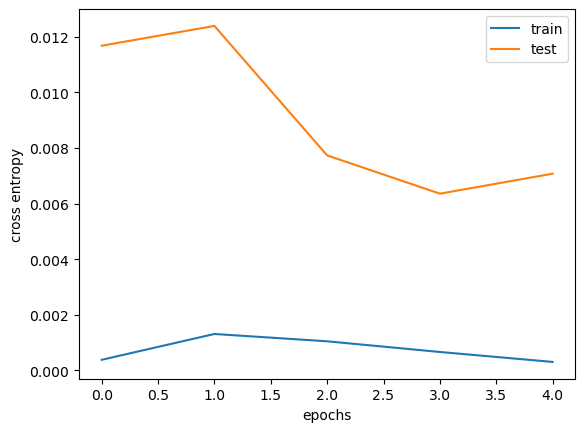

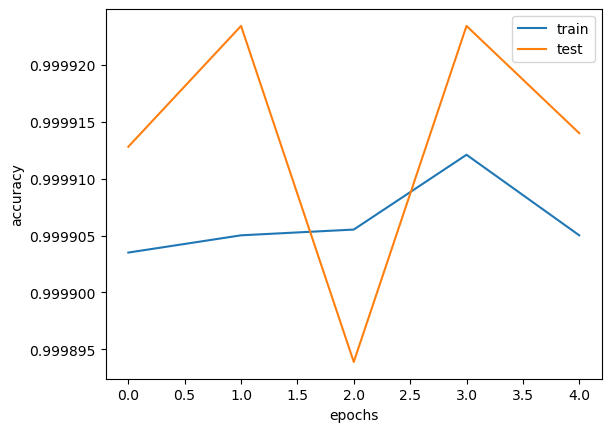

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_847152/221735082.py:120: UserWarning: Glyph 150 (\x96) missing from current font.
  plt.savefig('confusion_matrix.png')
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


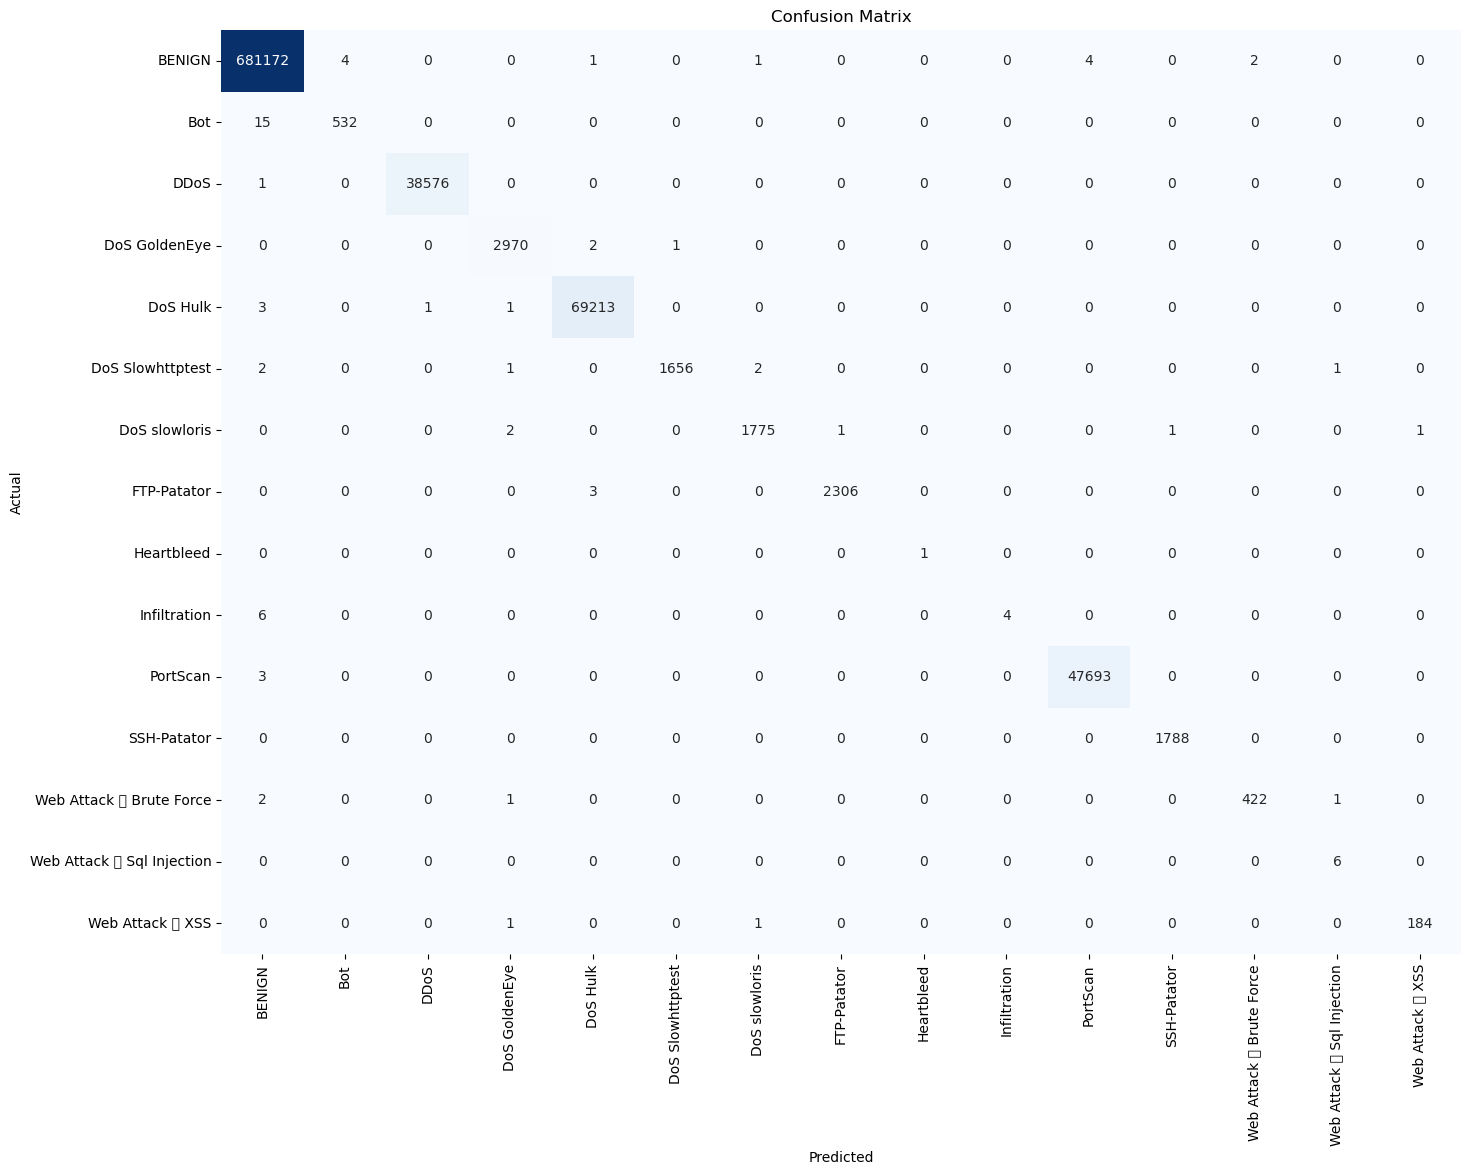

In [88]:
training_model(model=ann, 
               X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
               learning_rate=0.001, n_epochs=5, batch_size=512,
               categories_as_list=categories_as_list)